In [1]:
import os, sys, math, io
import numpy as np
import pandas as pd
import multiprocessing as mp
import bson
import struct

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf

from collections import defaultdict
from tqdm import *

data_dir = '/mnt/data/cdiscount/'

from subprocess import check_output
print(check_output(["ls", data_dir]).decode("utf8"))

# Any results you write to the current directory are saved as output.

category_names.csv
sample_submission.csv
test.bson
train.bson
train_example.bson



In [2]:
train_bson_path = os.path.join(data_dir, "train.bson")
num_train_products = 7069896

test_bson_path = os.path.join(data_dir, "test.bson")
num_test_products = 1768172

categories_path = os.path.join(data_dir, "category_names.csv")
categories_df = pd.read_csv(categories_path, index_col="category_id")

# Maps the category_id to an integer index. This is what we'll use to
# one-hot encode the labels.
categories_df["category_idx"] = pd.Series(range(len(categories_df)), index=categories_df.index)

#categories_df.to_csv("categories.csv")
categories_df.head()

,category_level1,category_level2,category_level3,category_idx
category_id,,,,
1000021794,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA,0
1000012764,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI FUMEUR,1
1000012776,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI VELO - ABRI MOTO,2
1000012768,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,FONTAINE A EAU,3
1000012755,AMENAGEMENT URBAIN - VOIRIE,SIGNALETIQUE,PANNEAU D'INFORMATION EXTERIEUR,4


In [3]:
print('number of categories = %d' % len(categories_df["category_idx"]))
print('number of category_level1 = %d' % len(categories_df["category_level1"].unique()))
print('number of category_level2 = %d' % len(categories_df["category_level2"].unique()))
print('number of category_level3 = %d' % len(categories_df["category_level3"].unique()))

number of categories = 5270
number of category_level1 = 49
number of category_level2 = 483
number of category_level3 = 5263


In [4]:
category_count = categories_df["category_level1"].value_counts()
print(category_count)

SPORT                                         555
BRICOLAGE - OUTILLAGE - QUINCAILLERIE         441
AUTO - MOTO                                   440
ART DE LA TABLE - ARTICLES CULINAIRES         237
JARDIN - PISCINE                              230
JEUX - JOUETS                                 230
LOISIRS CREATIFS - BEAUX ARTS - PAPETERIE     220
DECO - LINGE - LUMINAIRE                      206
ELECTROMENAGER                                196
HYGIENE - BEAUTE - PARFUM                     184
PUERICULTURE                                  180
LIBRAIRIE                                     162
ANIMALERIE                                    158
INFORMATIQUE                                  137
MEUBLE                                        106
MATERIEL MEDICAL                              104
PHOTO - OPTIQUE                               103
EPICERIE                                      101
PARAPHARMACIE                                  99
TV - VIDEO - SON                               89


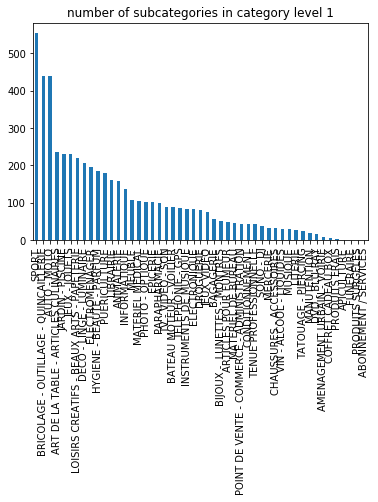

In [5]:
category_count.plot(kind='bar', title="number of subcategories in category level 1")

In [6]:
for category_level1 in categories_df["category_level1"].unique():
    print(category_level1)
    categories_level_df = categories_df.loc[categories_df["category_level1"] == category_level1]
    print(categories_level_df["category_level2"].value_counts())


ABONNEMENT / SERVICES
CARTE PREPAYEE    1
Name: category_level2, dtype: int64
AMENAGEMENT URBAIN - VOIRIE
SIGNALISATION ROUTIERE    3
AMENAGEMENT URBAIN        3
VOIRIE                    2
SIGNALETIQUE              1
Name: category_level2, dtype: int64
ANIMALERIE
VETEMENT - ACCESSOIRE                  18
HABITAT - COUCHAGE                     18
MATERIEL DE TOILETTAGE                 13
ALIMENTATION                           13
HYGIENE LITIERE DEJECTIONS             12
JOUET                                  12
ATTACHE - SELLERIE                     11
ACCESSOIRE POUR REPAS                  11
PRODUIT DE SOIN - HYGIENE              11
EDUCATION - ACTIVITE                    9
AMENAGEMENT TECHNIQUE DE L'HABITAT      8
SECURITE - PROTECTION                   7
TRANSPORT - DEPLACEMENT - PROMENADE     7
DECORATION DE L'HABITAT                 4
MATERNAGE - ELEVAGE                     4
Name: category_level2, dtype: int64
APICULTURE
OUTILS DE L'APICULTEUR    1
Name: category_level2, dtype: 

In [7]:
train_offsets_df = pd.read_csv("train_offsets.csv", index_col=0)

/home/weiso/tensorflow/lib/python3.5/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [8]:
train_offsets_df.head()

,num_imgs,offset,length,category_id
product_id,,,,
0,1,0,6979,1000010653
1,1,6979,7318,1000010653
2,1,14297,5455,1000004079
3,1,19752,4580,1000004141
4,1,24332,6346,1000015539


In [9]:
print('number of products = %d' % len(train_offsets_df))
print('number of catagories = %d' % len(train_offsets_df["category_id"].unique()))
print('number of images = %d' % train_offsets_df["num_imgs"].sum())

number of products = 7069896
number of catagories = 5270
number of images = 12371293


In [10]:
def make_category_tables():
    cat2idx = {}
    idx2cat = {}
    for ir in categories_df.itertuples():
        category_id = ir[0]
        category_idx = ir[4]
        cat2idx[category_id] = category_idx
        idx2cat[category_idx] = category_id
    return cat2idx, idx2cat

categories_df = pd.read_csv("categories.csv", index_col=0)
cat2idx, idx2cat = make_category_tables()

In [11]:
total_images_df = pd.read_csv('total_images.csv', index_col=0)
total_images_df.head()

/home/weiso/tensorflow/lib/python3.5/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,product_id,category_idx,img_idx
0,36254,619,0
1,42537,619,0
2,55264,619,0
3,104035,619,0
4,114584,619,0


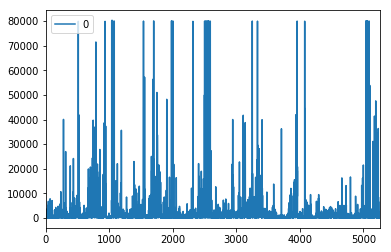

In [12]:
num_images_per_cat = []
for category_idx in range(len(categories_df)):
    num_images = np.sum(total_images_df["category_idx"] == category_idx)
    num_images_per_cat.append(num_images)

num_images_per_cat_df = pd.DataFrame(num_images_per_cat)
num_images_per_cat_df.plot()

In [13]:
num_images_per_cat_df.head()

,0
0,32
1,1999
2,44
3,56
4,341


In [15]:
num_images_per_cat_df['category_id'] = num_images_per_cat_df.index
num_images_per_cat_df['category_id'] = num_images_per_cat_df['category_id'].apply(lambda x: idx2cat[x])
num_images_per_cat_df.head()

,0,category_id
0,32,1000021794
1,1999,1000012764
2,44,1000012776
3,56,1000012768
4,341,1000012755


In [16]:
num_images_per_cat_df = num_images_per_cat_df.sort_values("count", ascending=False)
num_images_per_cat_df.head()

KeyError: 'count'

In [ ]:
#num_images_per_cat_df.plot(x='category_id', y='count', kind='bar', figsize=(25, 25))

In [ ]:
num_images_per_cat_larger_than_2000 = num_images_per_cat_df.loc[num_images_per_cat_df['count'] > 2000]
print(len(num_images_per_cat_larger_than_2000))